```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
import numpy as np
import subprocess
import csv
import StringIO

#Finally, import our simulator
from SWESimulators import FBL, CTCS, DataOutput

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Finally, import our simulator
from SWESimulators import FBL, CTCS, LxF, KP07, DataOutput, PlotHelper

In [2]:
swashes_path = r'C:\Users\anbro\Documents\programs\SWASHES-1.03.00_win\bin\swashes_win.exe'

In [3]:
#Execute swashes

swashes_args = [\
                '1', # 1D problems \
                '3', # Dam breaks \
                '1', # Domain 1 \
                '1', # Wet domain no friction
                '1000' #Number of cells X
               ]

p = subprocess.Popen([swashes_path] + swashes_args, stdout=subprocess.PIPE, stderr= subprocess.PIPE)
out, err = p.communicate()
if (err):
    print "Errors:"
    print err
    print "Output: "
    print out
else:
    #Print first N lines 
    N = 20
    tmp = out.split('\n')[:N]
    print "\n".join(tmp)
    print "[...]"

##############################################################################
# Generated by SWASHES version 1.03.00, 2016-01-29
##############################################################################
# Dimension: 1
# Type: 3 (=Dam break)
# Domain: 1
# Choice: 1 (=on a wet domain without friction (Stoker's solution))
##############################################################################
# PARAMETERS OF THE SOLUTION
# 
# Length of the domain: 10 meters
# Space step: 0.01 meters
# Number of cells: 1000
# Position of the dam: x=5 meters
# Time value: 6 seconds
##############################################################################
# 
#(i-0.5)*dx 	    h[i] 	    u[i] 	 topo[i] 	    q[i] 	 topo[i]+h[i] 	Fr[i]=Froude	 topo[i]+hc[i] 	
0.005	    0.005	        0	        0	        0	    0.005	        0	        0	
0.015	    0.005	        0	        0	        0	    0.005	        0	        0	
[...]


In [4]:
#parse results

csv_file = StringIO.StringIO(out)
reference = np.genfromtxt(csv_file, comments='#', delimiter='\t', skip_header=0, usecols=(0, 1, 2))

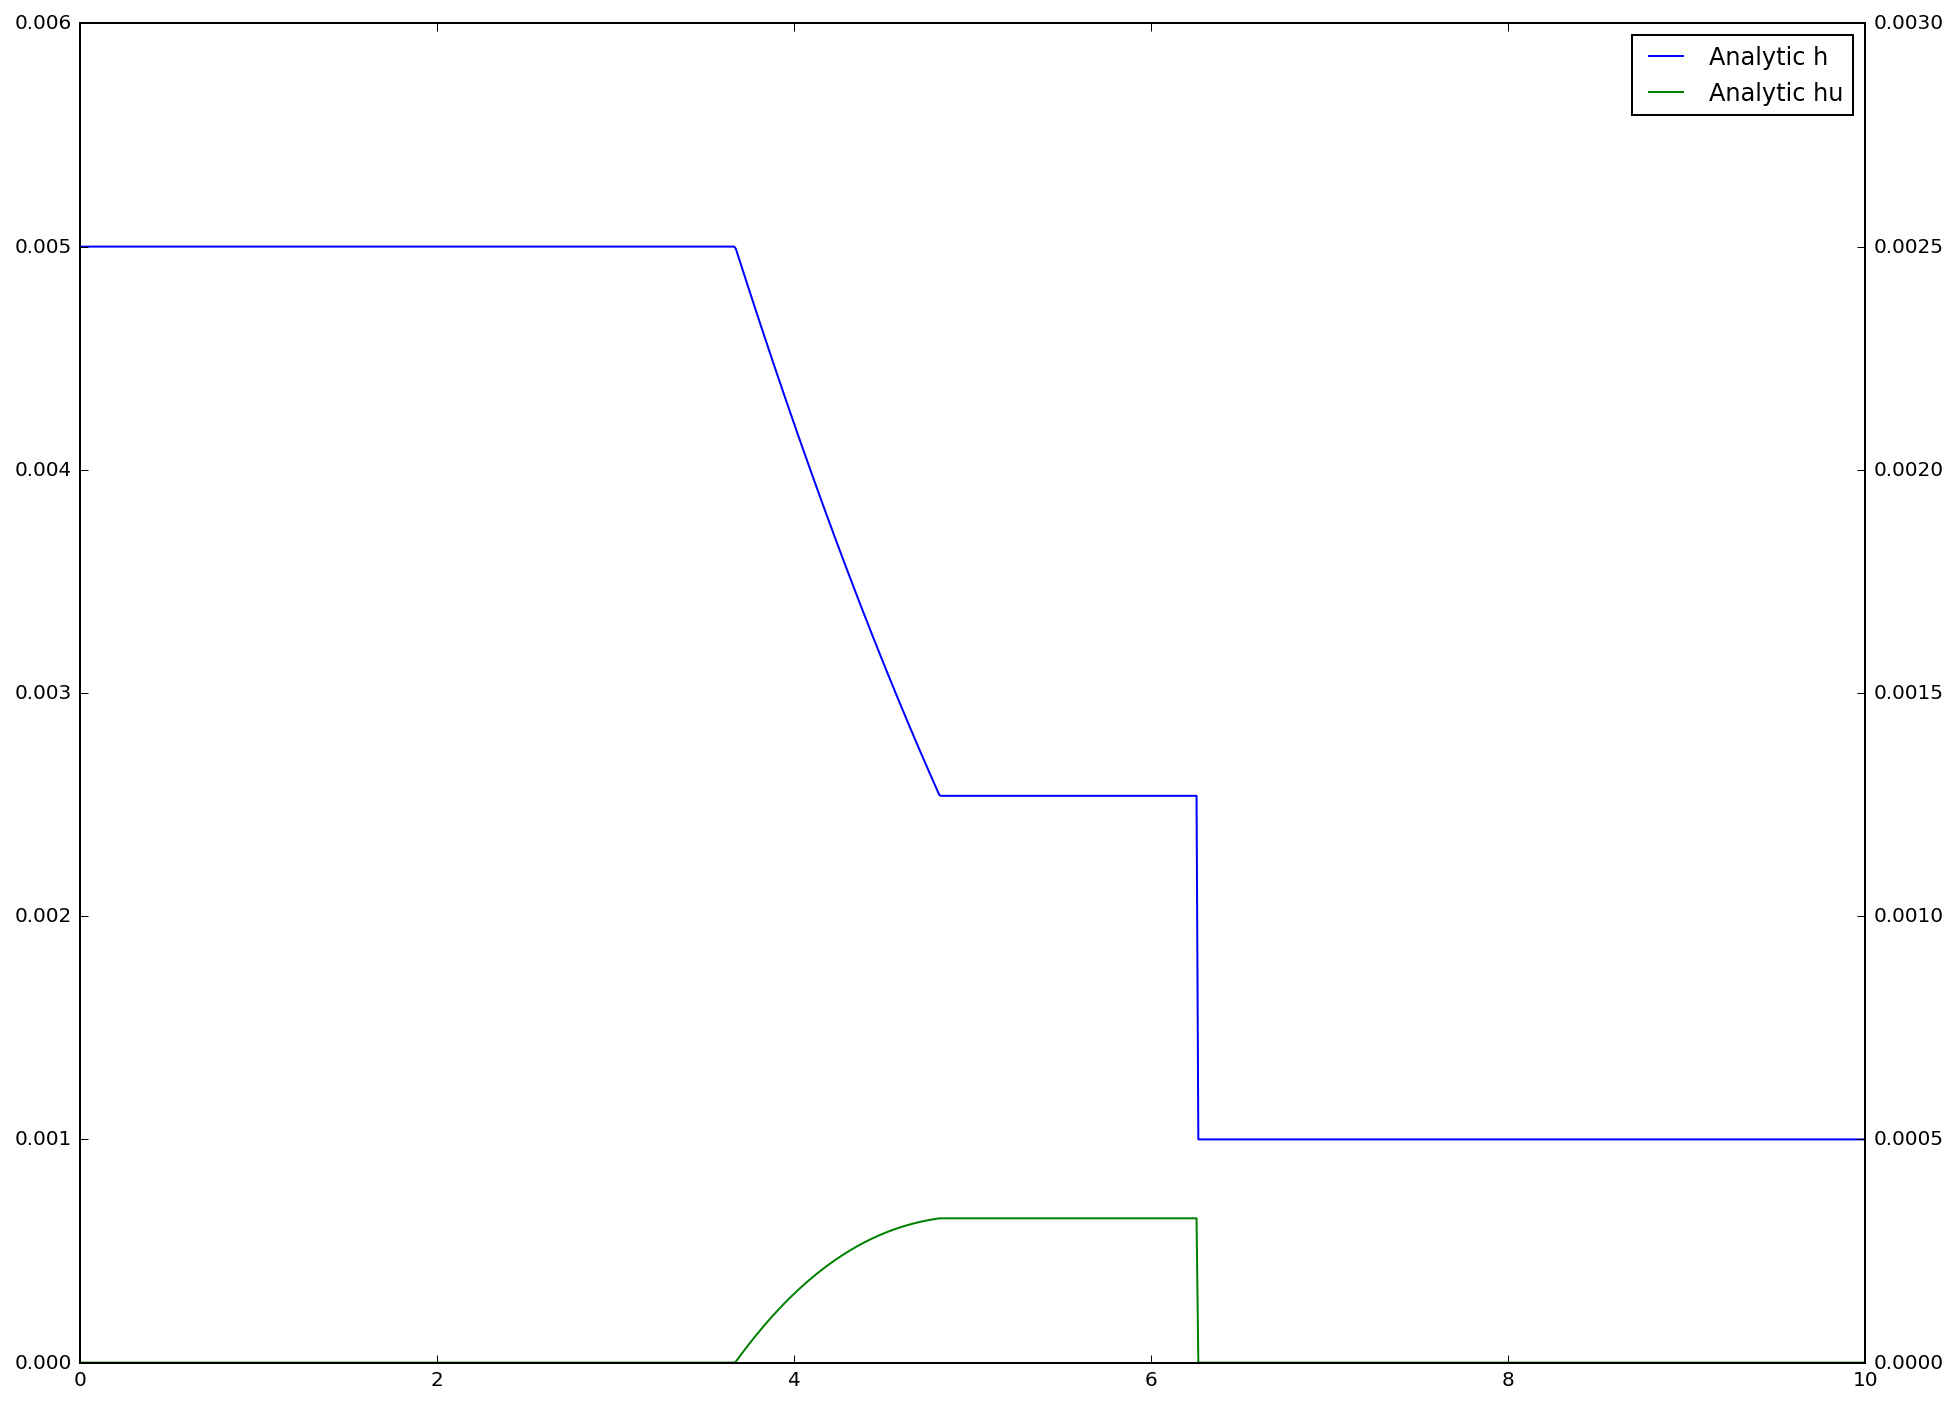

In [5]:
#Plot h
fig, ax1 = plt.subplots()
h = ax1.plot(reference[:,0], reference[:,1], 'b', label='Analytic h')
plt.axis([0, 10, 0, 0.006])

#Plot hu
ax2 = ax1.twinx()
u = ax2.plot(reference[:,0], reference[:,1]*reference[:,2], 'g', label='Analytic hu')
plt.axis([0, 10, 0, 0.003])

#Add legend
plots = h+u
labels = [l.get_label() for l in plots]
ax2.legend(plots, labels, loc=0)

Using  GeForce 840M
Reference sum: 0.03
Computed sum: 0.03


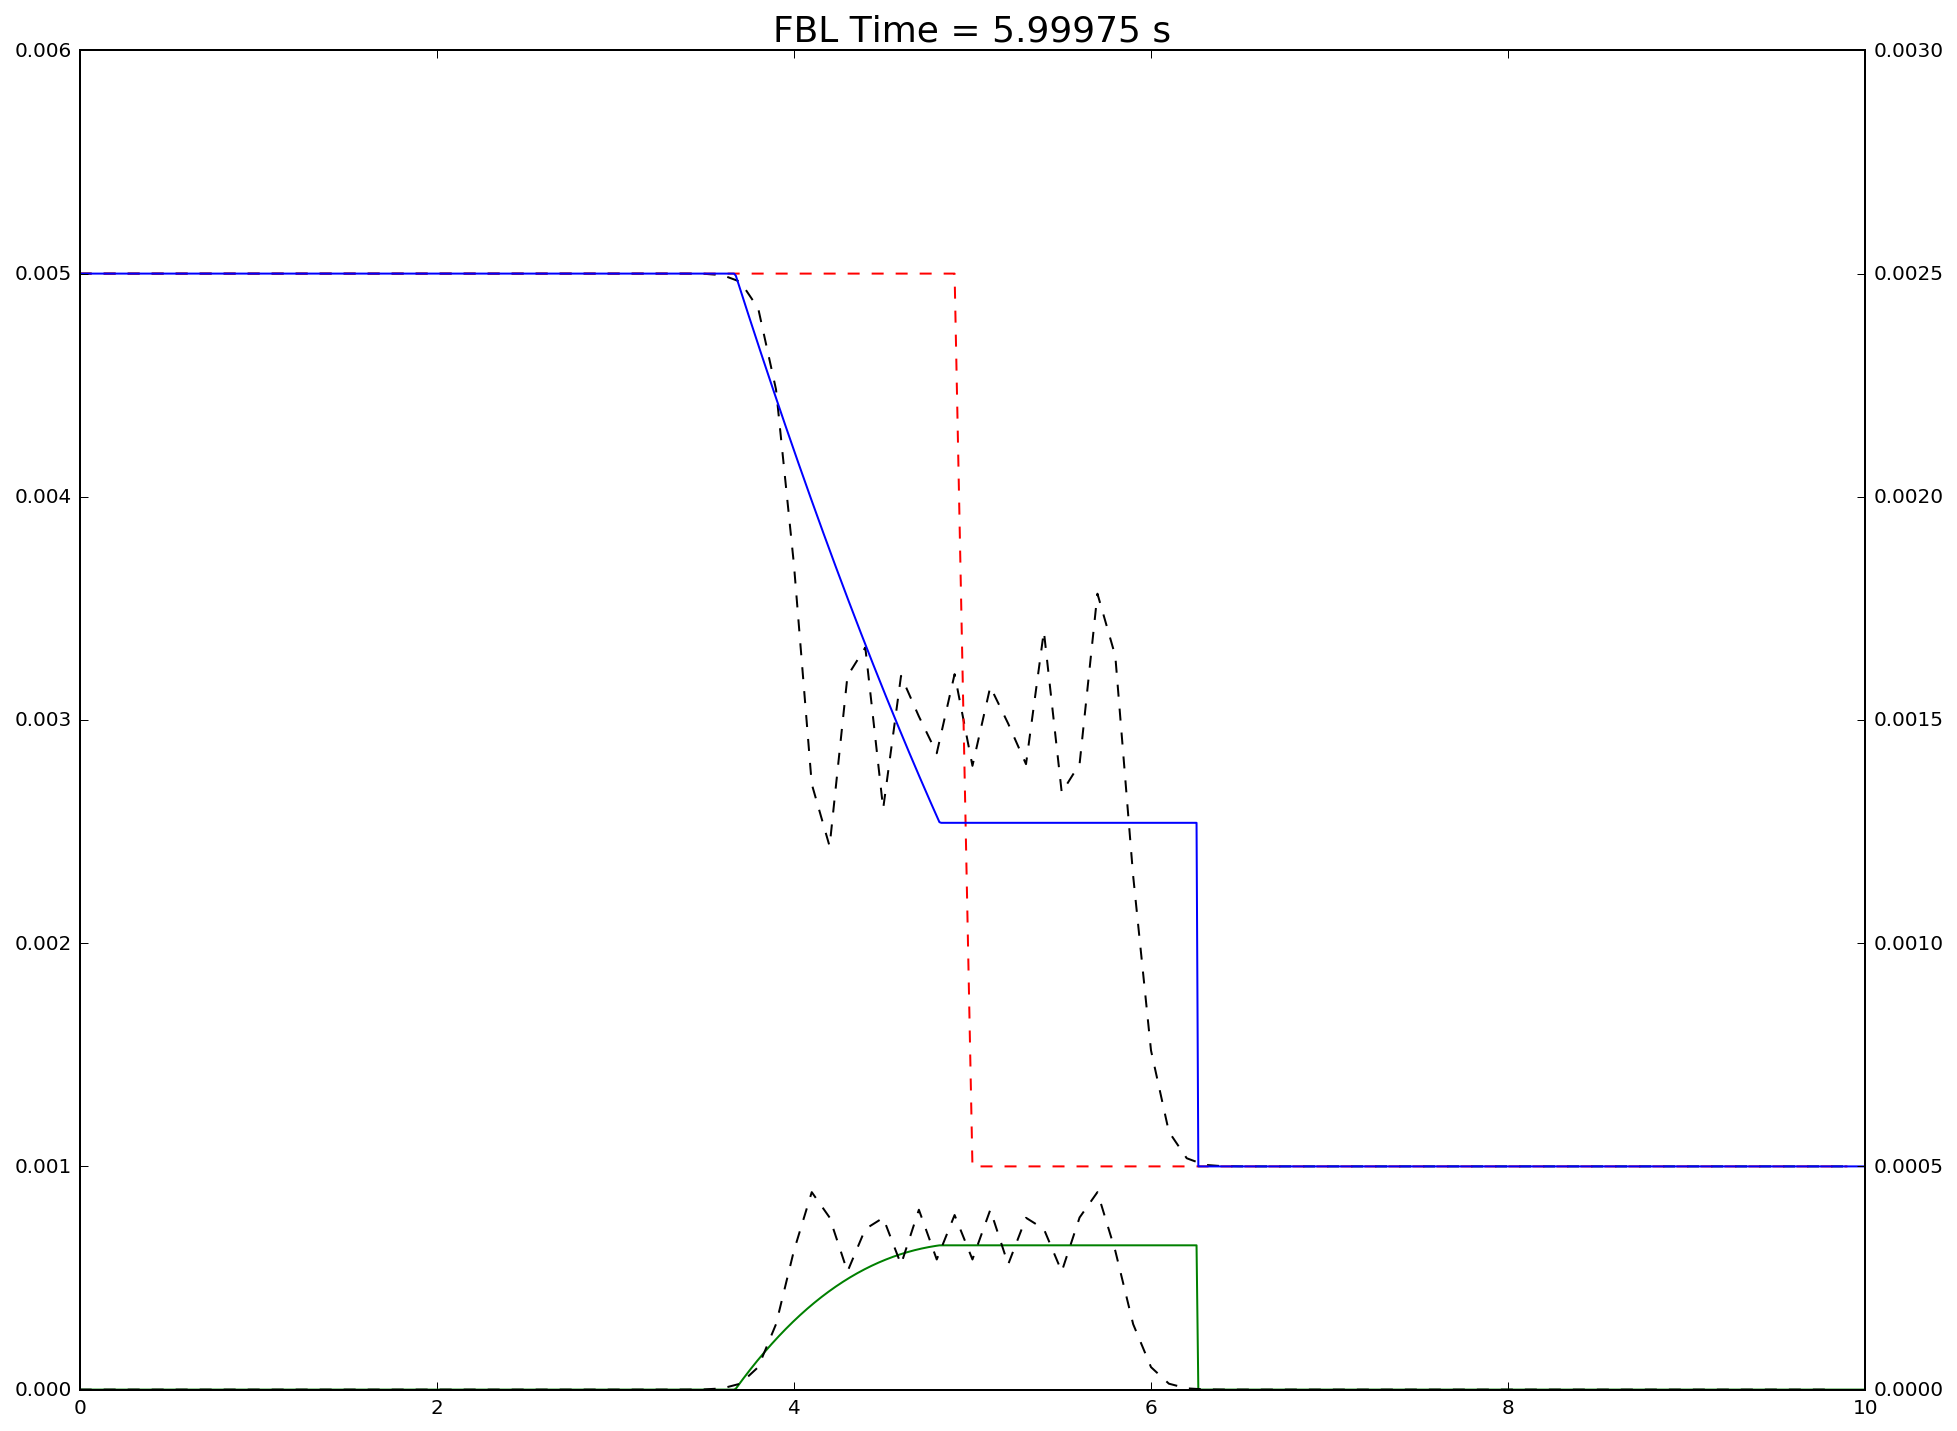

In [7]:
#Centered in time, centered in space

nx = 100
ny = 1

dx = 10.0 / float(nx)
dy = 1.0

dt = 0.001
g = 9.81
f = 0.0
r = 0.0

h0 = np.ones((ny, nx), dtype=np.float32, order='C') * 0.003;
eta0 = np.zeros((ny, nx), dtype=np.float32, order='C');
u0 = np.zeros((ny, nx+1), dtype=np.float32, order='C');
v0 = np.zeros((ny+1, nx), dtype=np.float32, order='C');

#Create dam break
for j in range(0, ny):
    for i in range(0, nx):
        x = dx*(i)
        
        if (x < 5):
            eta0[j, i] = 0.005 - h0[j, i]
        else:
            eta0[j, i] = 0.001 - h0[j, i]
            
#Initialize simulator
sim = FBL.FBL(h0, eta0, u0, v0, \
                nx, ny, \
                dx, dy, dt, \
                g, f, r)


#Calculate radius from center of bump for plotting
y_coords, x_coords = np.mgrid[0:ny*dy:dy, 0:nx*dx:dx]

t = sim.step(6.0)
eta1, u1, v1 = sim.download()

fig, ax1 = plt.subplots()
plt.title("FBL Time = " + str(t) + " s", fontsize=18)
ax1.plot(x_coords[0,:], h0[0, :] + eta1[0, :], 'k--')
ax1.plot(x_coords[0,:], h0[0, :] + eta0[0, :], 'r--')
ax1.plot(reference[:,0], reference[:,1], 'b', label='Analytic h')
plt.axis([0, 10, 0, 0.006])

ax2 = ax1.twinx()
ax2.plot(reference[:,0], reference[:,1]*reference[:,2], 'g', label='Analytic hu')
ax2.plot(x_coords[0,0:-1], u1[0, 1:-1], 'k--')
plt.axis([0, 10, 0, 0.003])

print "Reference sum: " + str(np.sum((h0[0, :] + eta0[0, :])*dx))
print "Computed sum: " + str(np.sum((h0[0, :] + eta1[0, :])*dx))

Using  GeForce 840M
Reference sum: 0.03
Computed sum: 0.03


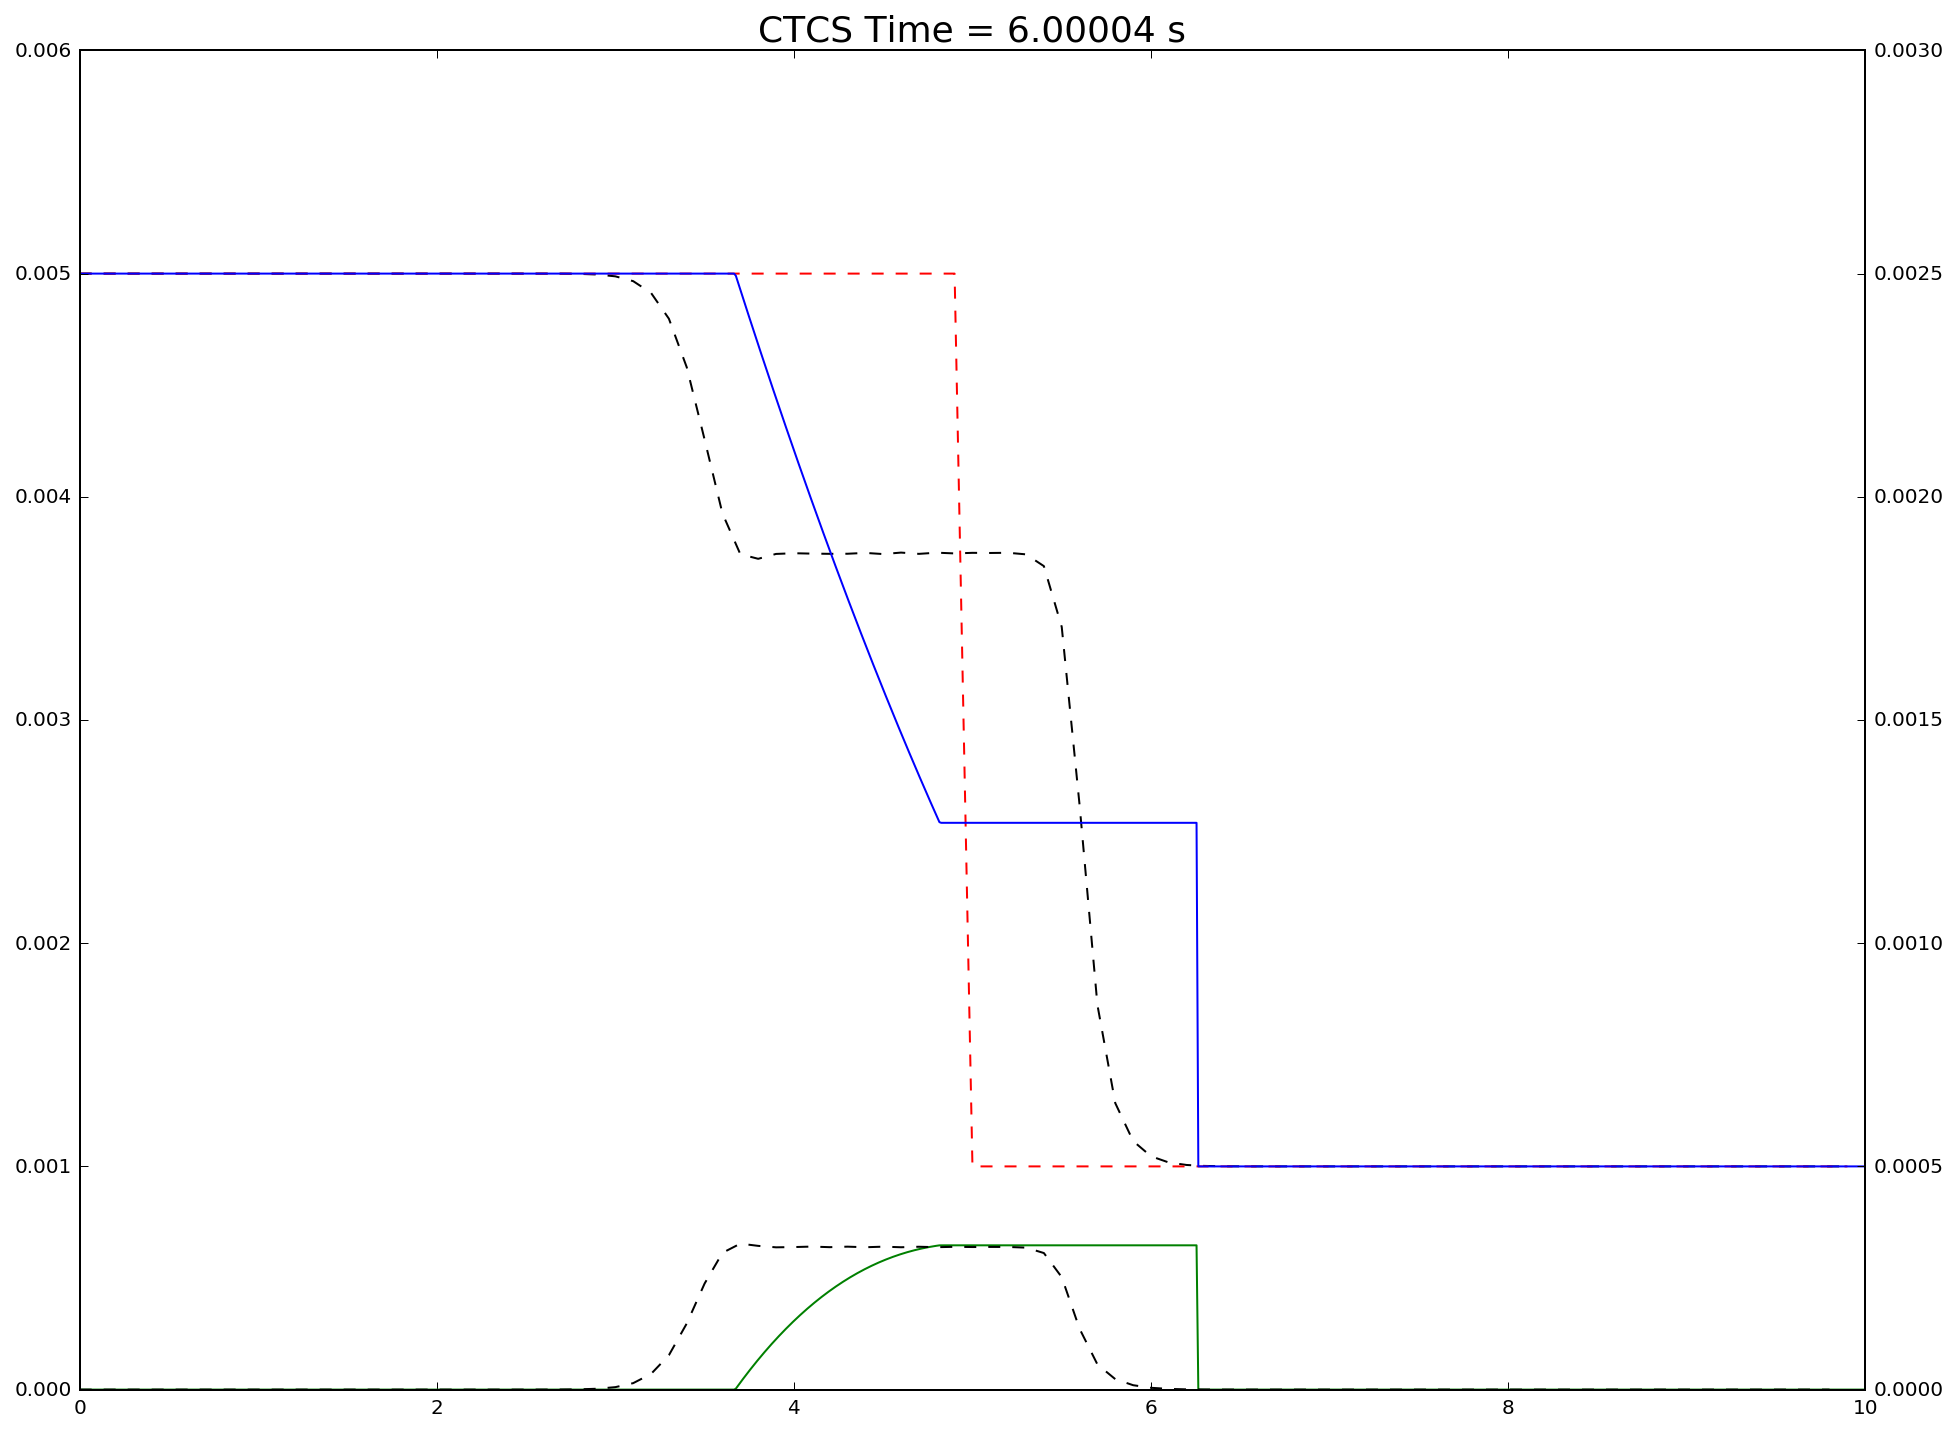

In [9]:
#Centered in time, centered in space

nx = 100
ny = 1

dx = 10.0 / float(nx)
dy = 1.0

dt = 0.01
g = 9.81
f = 0.0
r = 0.0
A = 0.008

h0 = np.ones((ny+2, nx+2), dtype=np.float32, order='C') * 0.001; 
eta0 = np.zeros((ny+2, nx+2), dtype=np.float32, order='C');
u0 = np.zeros((ny+2, nx+1), dtype=np.float32, order='C');
v0 = np.zeros((ny+1, nx+2), dtype=np.float32, order='C');

#Create dam break
for j in range(-1, ny+1):
    for i in range(-1, nx+1):
        x = dx*i # -1 because of ghost cells
        
        if (x < 5):
            eta0[j+1, i+1] = 0.005 - h0[j, i]
        else:
            eta0[j+1, i+1] = 0.001 - h0[j, i]
            
#Calculation of optimal dt
#ds = 2.0*sqrt(dx*dx + dy*dy)
#H_max = (h0 + eta0).max()
#c0 = sqrt(g*H_max)
#dt = 0.9*ds / c0
#print dt


#Initialize simulator
reload(CTCS)
sim = CTCS.CTCS(h0, eta0, u0, v0, \
                nx, ny, \
                dx, dy, dt, \
                g, f, r, A)


#Calculate radius from center of bump for plotting
y_coords, x_coords = np.mgrid[0:ny*dy:dy, 0:nx*dx:dx]

t = sim.step(6.0)
eta1, u1, v1 = sim.download()

fig, ax1 = plt.subplots()
plt.title("CTCS Time = " + str(t) + " s", fontsize=18)
ax1.plot(x_coords[0,:], h0[1, 1:-1] + eta1[1, 1:-1], 'k--')
ax1.plot(x_coords[0,:], h0[1, 1:-1] + eta0[1, 1:-1], 'r--')
ax1.plot(reference[:,0], reference[:,1], 'b', label='Analytic h')
plt.axis([0, 10, 0, 0.006])

ax2 = ax1.twinx()
ax2.plot(reference[:,0], reference[:,1]*reference[:,2], 'g', label='Analytic hu')
ax2.plot(x_coords[0,0:-1], u1[1, 1:-1], 'k--')
plt.axis([0, 10, 0, 0.003])

print "Reference sum: " + str(np.sum((h0[1, 1:-1] + eta0[1, 1:-1])*dx))
print "Computed sum: " + str(np.sum((h0[1, 1:-1] + eta1[1, 1:-1])*dx))

Using  GeForce 840M
Reference sum: 0.03
Computed sum: 0.03


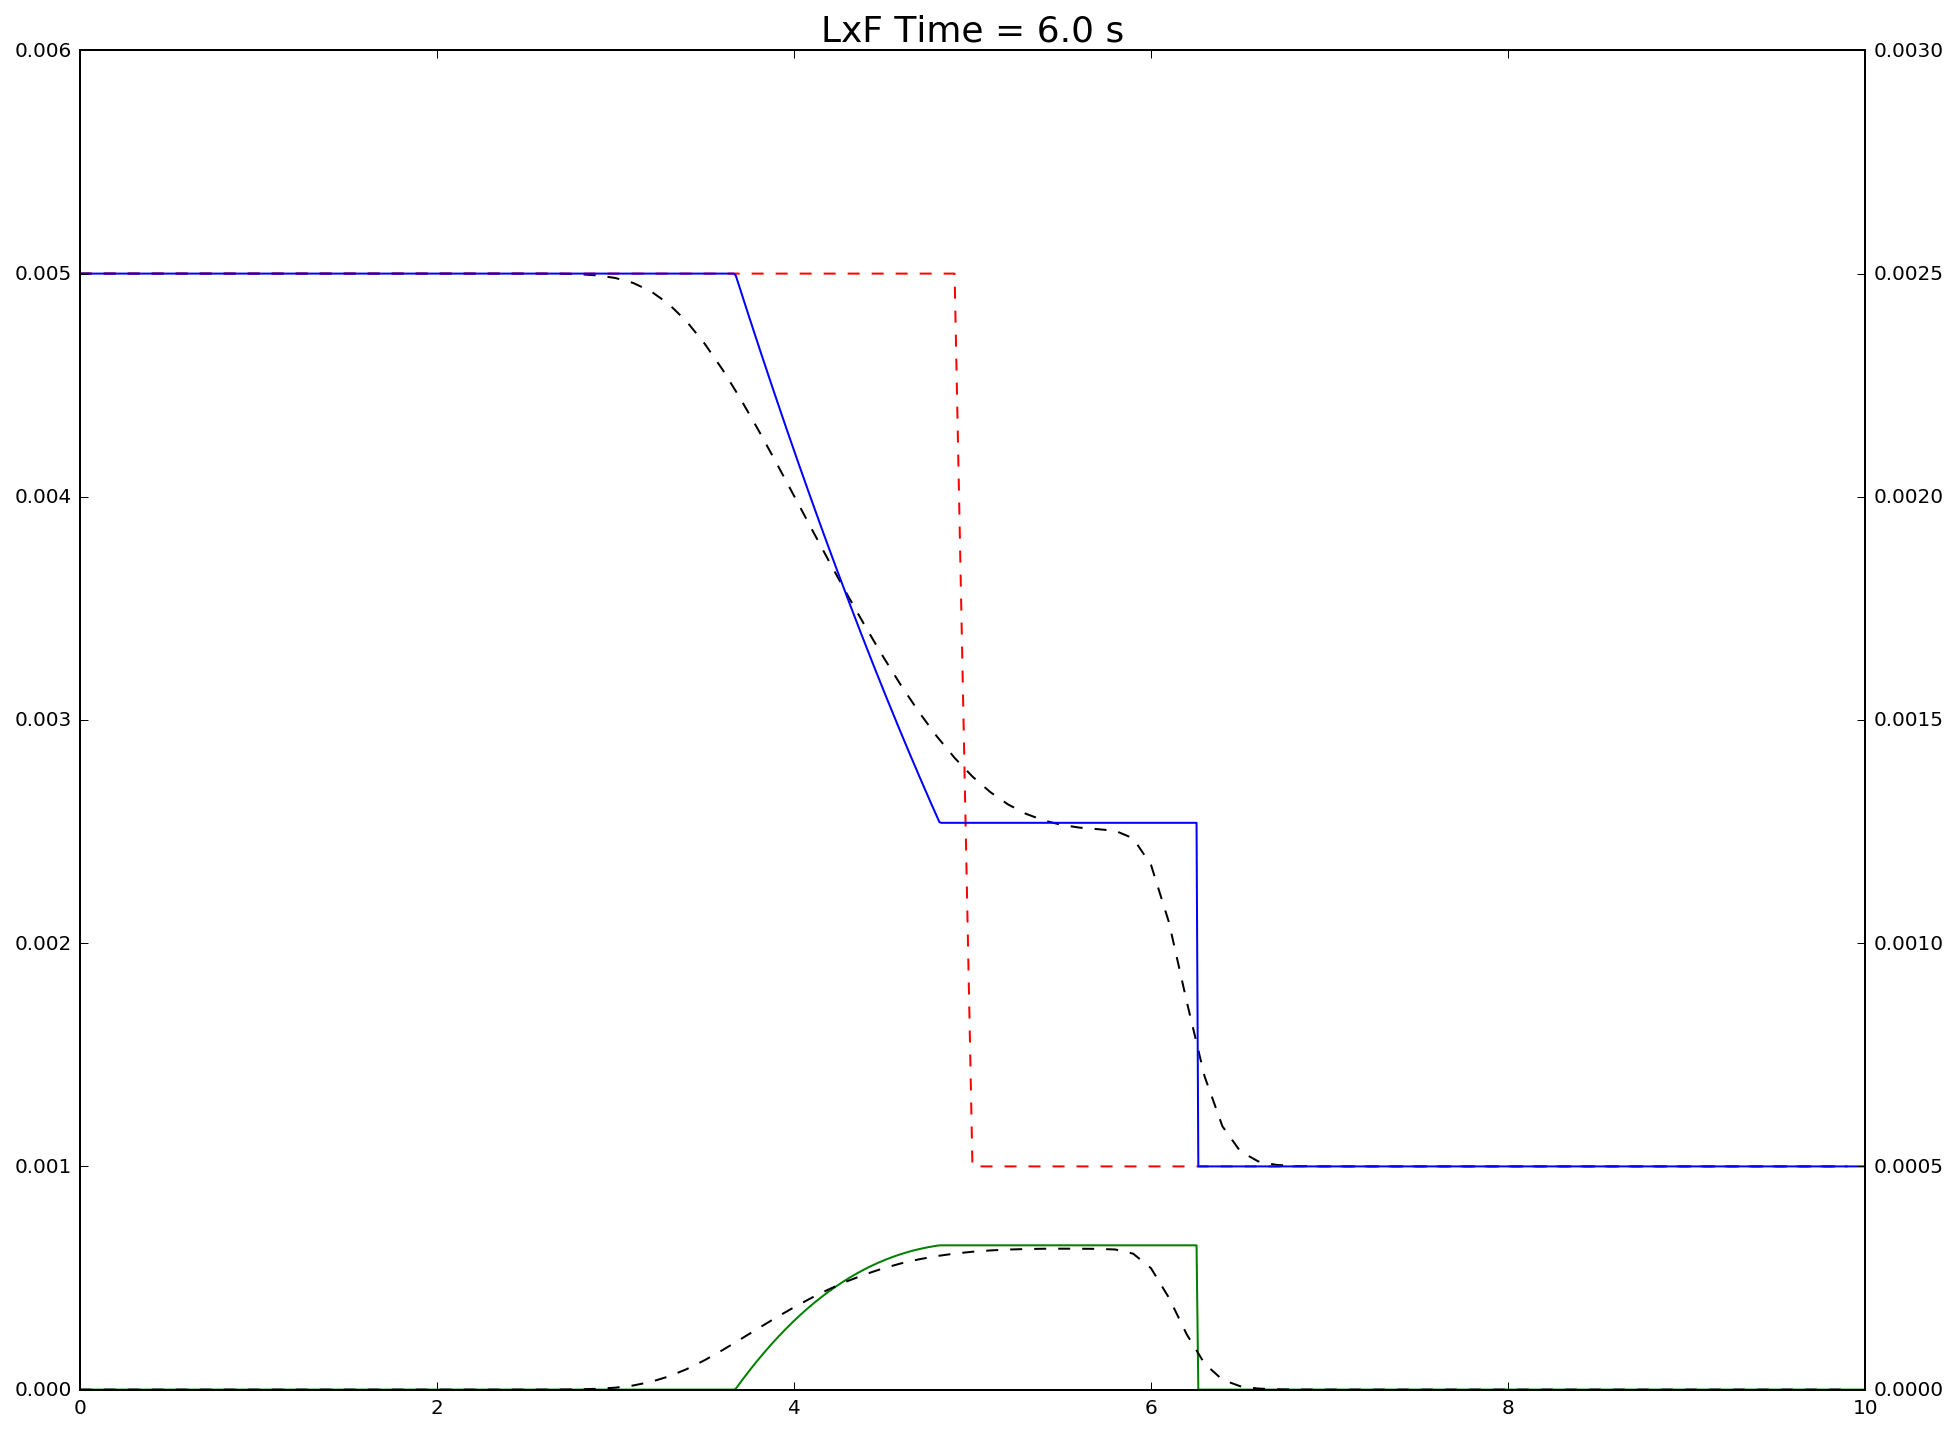

In [10]:
#Lax Friedrichs

nx = 100
ny = 1

dx = 10.0 / float(nx)
dy = 1.0

dt = 0.2
g = 9.81

h0 = np.zeros((ny+2, nx+2), dtype=np.float32, order='C'); 
u0 = np.zeros((ny+2, nx+2), dtype=np.float32, order='C');
v0 = np.zeros((ny+2, nx+2), dtype=np.float32, order='C');

#Create dam break
for j in range(-1, ny+1):
    for i in range(-1, nx+1):
        x = dx*i
        
        if (x < 5):
            h0[j+1, i+1] = 0.005
        else:
            h0[j+1, i+1] = 0.001


#Initialize simulator
reload(LxF)
sim = LxF.LxF(h0, u0, v0, \
                nx, ny, \
                dx, dy, dt, \
                g)


#Calculate radius from center of bump for plotting
y_coords, x_coords = np.mgrid[0:ny*dy:dy, 0:nx*dx:dx]

t = sim.step(6.0)
h1, u1, v1 = sim.download()

fig, ax1 = plt.subplots()
plt.title("LxF Time = " + str(t) + " s", fontsize=18)
ax1.plot(x_coords[0,:], h1[1, 1:-1], 'k--')
ax1.plot(x_coords[0,:], h0[1, 1:-1], 'r--')
ax1.plot(reference[:,0], reference[:,1], 'b', label='Analytic h')
plt.axis([0, 10, 0, 0.006])

ax2 = ax1.twinx()
ax2.plot(reference[:,0], reference[:,1]*reference[:,2], 'g', label='Analytic hu')
ax2.plot(x_coords[0,:], u1[1, 1:-1], 'k--')
plt.axis([0, 10, 0, 0.003])

print "Reference sum: " + str(np.sum(h0[1, 1:-1]*dx))
print "Computed sum: " + str(np.sum(h1[1, 1:-1]*dx))

Using  GeForce 840M
Reference sum: 0.03
Computed sum: 0.03


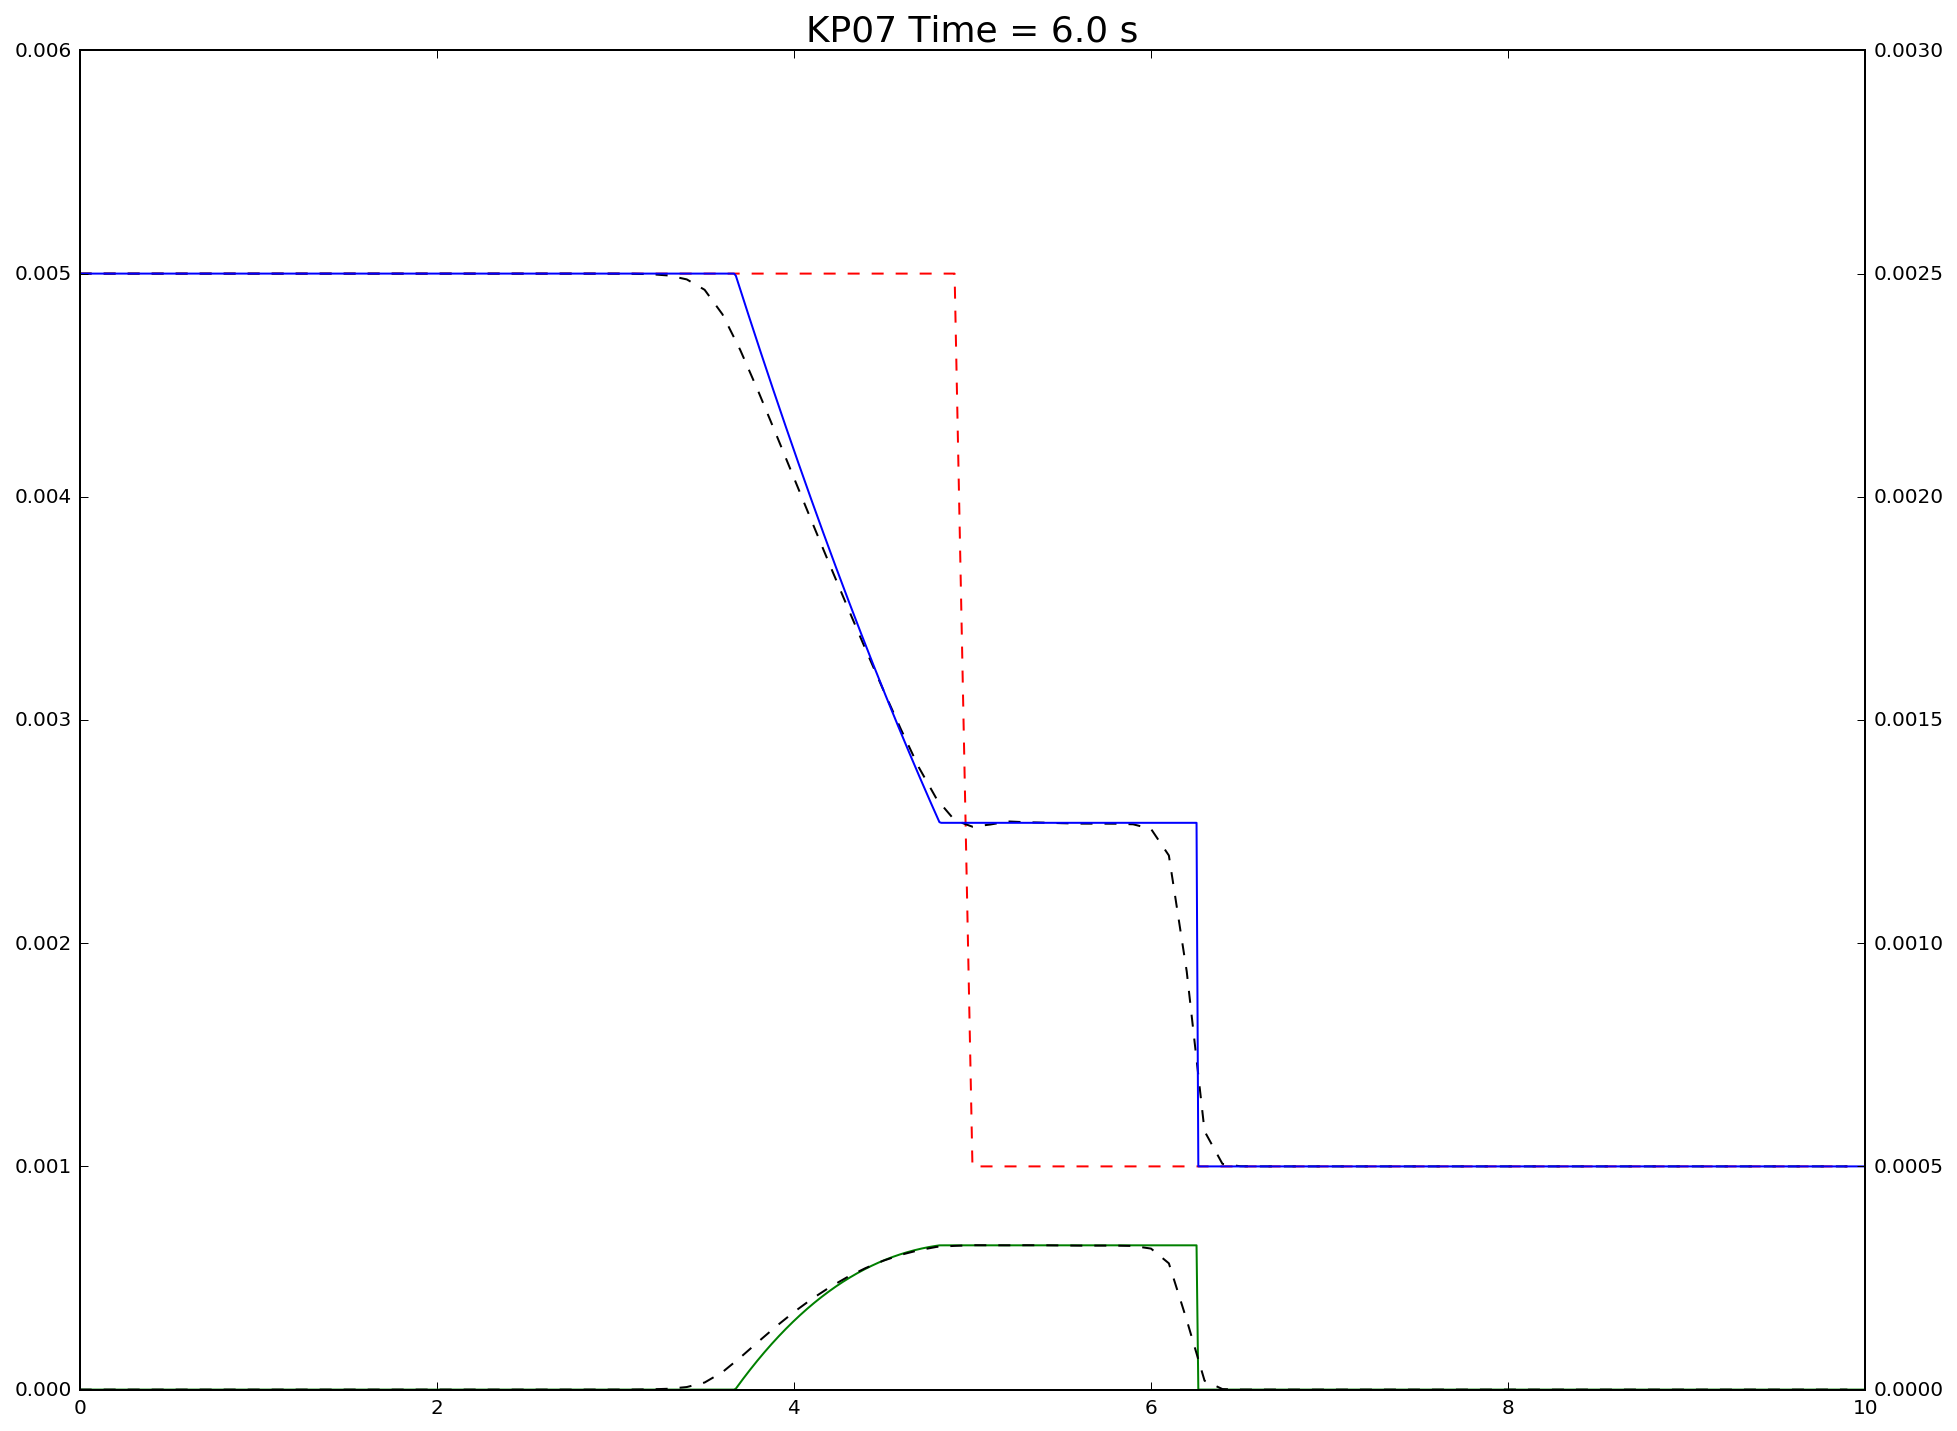

In [11]:
#Lax Friedrichs

nx = 100
ny = 1

dx = 10.0 / float(nx)
dy = 1.0

dt = 0.02
g = 9.81

h0 = np.zeros((ny+4, nx+4), dtype=np.float32, order='C'); 
u0 = np.zeros((ny+4, nx+4), dtype=np.float32, order='C');
v0 = np.zeros((ny+4, nx+4), dtype=np.float32, order='C');

#Create dam break
for j in range(-2, ny+2):
    for i in range(-2, nx+2):
        x = dx*i
        
        if (x < 5.0):
            h0[j+2, i+2] = 0.005
        else:
            h0[j+2, i+2] = 0.001


#Initialize simulator
reload(KP07)
sim = KP07.KP07(h0, u0, v0, \
                nx, ny, \
                dx, dy, dt, \
                g)


#Calculate radius from center of bump for plotting
y_coords, x_coords = np.mgrid[0:ny*dy:dy, 0:nx*dx:dx]

t = sim.step(6.0)
h1, u1, v1 = sim.download()

fig, ax1 = plt.subplots()
plt.title("KP07 Time = " + str(t) + " s", fontsize=18)
ax1.plot(x_coords[0,:], h0[2, 2:-2], 'r--')
ax1.plot(x_coords[0,:], h1[2, 2:-2], 'k--')
ax1.plot(reference[:,0], reference[:,1], 'b', label='Analytic h')
plt.axis([0, 10, 0, 0.006])


ax2 = ax1.twinx()
ax2.plot(reference[:,0], reference[:,1]*reference[:,2], 'g', label='Analytic hu')
ax2.plot(x_coords[0,:], u1[2, 2:-2], 'k--')
plt.axis([0, 10, 0, 0.003])

print "Reference sum: " + str(np.sum(h0[2, 2:-2]*dx))
print "Computed sum: " + str(np.sum(h1[2, 2:-2]*dx))